In [ ]:
#드라이브 마운트 - 구글 드라이브의 데이터를 가져올 때 가져오는 라이브러리
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#필요한 모듈 import
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA

In [ ]:
#train data 가져오기
train = pd.read_csv('/content/sample_data/train.csv')
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


1. 각 방법별로 price_range에 영향을 미치는 top 4 features 고르기
- Correlation(ram, battery_power, px_width, px_height)
- Chi-square test(ram, px_height, battery_power, px_width)
- Forward feature selection(battery_power, px_height, px_width, ram)
- Lasso Regression(ram, battery_power, px_width, px_height)
- PCA(ram, battety_power, px_width, px_height)

=> battery_power, ram, px_width, px_height가 결과로 나옴

In [ ]:
#train data feature, label 분리
#all data(train), feature data(train_x), label data(train_y)
X = train.drop(["price_range"], axis=1)
Y = train.loc[:, ["price_range"]]
print("feature num : ", len(X.dtypes))
print("label num : ", len(Y.dtypes))

#추출한 column 확인
columns = pd.DataFrame(X.columns)
print(columns)

feature num :  20
label num :  1
                0
0   battery_power
1            blue
2     clock_speed
3        dual_sim
4              fc
5          four_g
6      int_memory
7           m_dep
8       mobile_wt
9         n_cores
10             pc
11      px_height
12       px_width
13            ram
14           sc_h
15           sc_w
16      talk_time
17        three_g
18   touch_screen
19           wifi


In [ ]:
#Correlation
corr = train.corr()['price_range'][:-1]
print(corr.sort_values(ascending=False)[:4])

ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
Name: price_range, dtype: float64


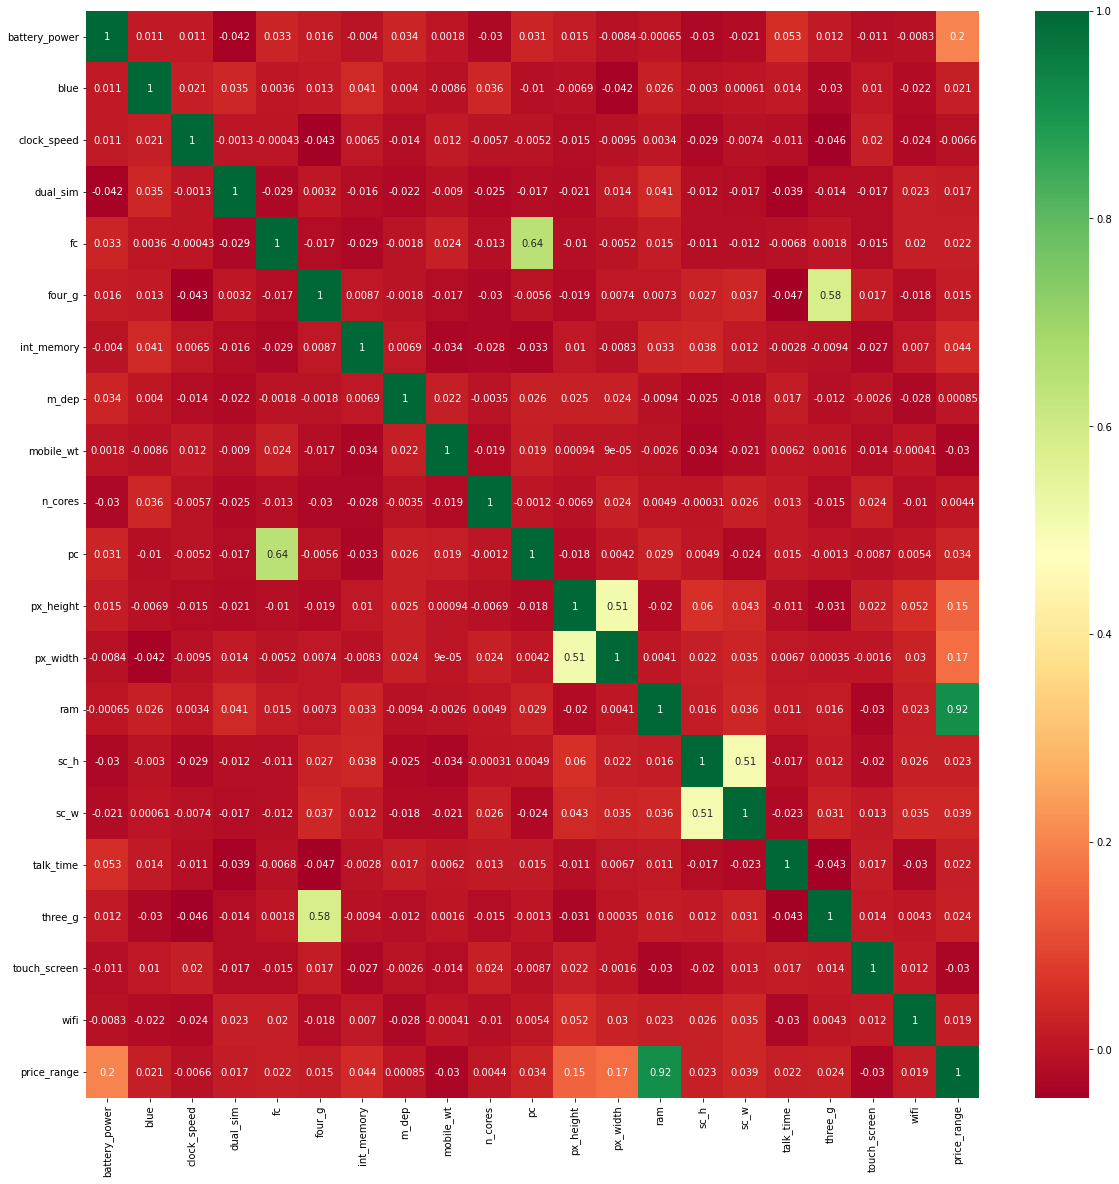

In [ ]:
# correlation을 heatmap으로 확인했을 때의 결과도 동일
#get correlations of each features in dataset
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
#Chi-square test
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)

#
chi = pd.DataFrame(fit.scores_)
df = pd.concat([columns, chi], axis=1)
df.columns = ["columns", "chi"]
print(df.sort_values(by="chi", ascending=False)[:4])


          columns            chi
13            ram  931267.519053
11      px_height   17363.569536
0   battery_power   14129.866576
12       px_width    9810.586750


In [ ]:
#Forward feature selection
#구글링하다가 찾은 함수이지만 정확하게 이해하지는 못함
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features[:4]

feature = forward_selection(X, Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: Depr

In [ ]:
print(feature)

['ram', 'battery_power', 'px_height', 'px_width']


In [ ]:
#forward selection 위한 built-in 함수 다운
!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#forward selection
sfs = SFS(LogisticRegression(), k_features=4, forward=True, floating=False, scoring = 'r2', cv = 0)
sfs.fit(X,Y)
feature = sfs.k_feature_names_

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [ ]:
print(feature)

('battery_power', 'px_height', 'px_width', 'ram')


In [ ]:
#Lasso Regression
lasso = Lasso().fit(X, Y)
coef = pd.DataFrame(lasso.coef_)

# columns랑 합치기
df = pd.concat([columns, coef], axis=1)
df.columns = ["columns", "coef"]
print(df.sort_values(by="coef", ascending=False)[:4])

          columns      coef
13            ram  0.000947
0   battery_power  0.000505
12       px_width  0.000275
11      px_height  0.000273


In [ ]:
#PCA
scaler = StandardScaler()
scaler_X = scaler.fit_transform(X)

pca = PCA()
pca.fit(scaler_X)

PCA = pd.DataFrame(pca.explained_variance_)


# columns랑 합치기
df = pd.concat([columns, coef], axis=1)
df.columns = ["columns", "PCA"]

#오름차순 정렬
print(df.sort_values(by="PCA", ascending=False)[:4])


          columns       PCA
13            ram  0.000947
0   battery_power  0.000505
12       px_width  0.000275
11      px_height  0.000273


2. top 4와 전체 feature로 학습한 모델 정확도 비교

- top 4 accuracy : 94.75%
- 전체 accuracy : 64%



In [ ]:
#필요한 모듈 import
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

In [ ]:
#train, test data split 후 확인
train_x, test_x, train_y, test_y = train_test_split(X, Y, stratify=Y, train_size=0.8, test_size=0.2, random_state=5)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1600, 20) (400, 20) (1600, 1) (400, 1)


In [ ]:
#Top-4 feature accuracy : 94.75%
feature_names =["battery_power", "ram", "px_width", "px_height"]

# top 4 feature data 준비
dfx = train[feature_names].copy()
dfy = Y.copy()
dfx["battery_power"] = LabelEncoder().fit_transform(dfx["battery_power"])
dfx["ram"] = LabelEncoder().fit_transform(dfx["ram"])
dfx["px_width"] = LabelEncoder().fit_transform(dfx["px_width"])
dfx["px_height"] = LabelEncoder().fit_transform(dfx["px_height"])

# top 4 feature data split
train4_x, test4_x, train4_y, test4_y = train_test_split(dfx, dfy, stratify=dfy, train_size=0.8, test_size=0.2, random_state=5)

# train data로 모델 학습 및 test data 정확도 출력
model = LogisticRegression()
model.fit(train4_x, train4_y)
print(model.score(test4_x, test4_y))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9475


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
#전체 모델 accuracy : 64%
# 모델 학습 및 정확도 출력
model = LogisticRegression()
model.fit(train_x, train_y)
print(model.score(test_x, test_y))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.64


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


3. PCA/t-SNE로 training data visualize 후 비교


In [ ]:
#필요한 모듈 import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
#train, test data split 후 확인
train_x, test_x, train_y, test_y = train_test_split(X, Y, stratify=Y, train_size=0.8, test_size=0.2, random_state=5)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(1600, 20) (400, 20) (1600, 1) (400, 1)


[Text(0.5, 1.0, 'PCA Visualize')]

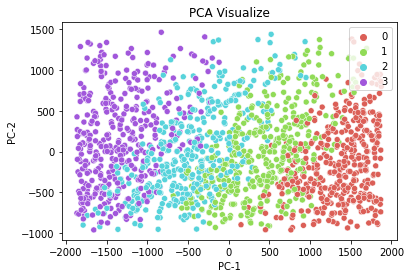

In [ ]:
#PCA로 visualize
pca = PCA(n_components=2, random_state = 6) #차원 수 지정
pc = pca.fit_transform(train_x)

df = pd.DataFrame()
df["price_range"] = train_y
df["PC-1"] = pc[:,0]
df["PC-2"] = pc[:,1]

# 시각화
sns.scatterplot(x="PC-1", y="PC-2", hue=df.price_range.tolist(),
                palette=sns.color_palette("hls",4),
                data=df).set(title="PCA Visualize")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.000s...
[t-SNE] Computed neighbors for 1600 samples in 0.122s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 263.686331
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.768753
[t-SNE] KL divergence after 1000 iterations: 1.073759


[Text(0.5, 1.0, 'T-SNE Visualize')]

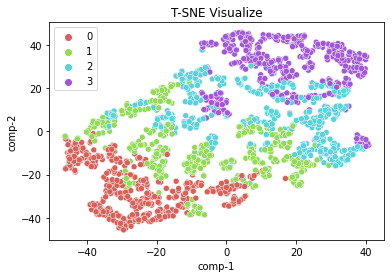

In [ ]:
#t-SNE로 visualize
tsne = TSNE(n_components=2, verbose=1, random_state = 7) #차원 수 지정
t = tsne.fit_transform(train_x)

df = pd.DataFrame()
df["price_range"] = train_y
df["comp-1"] = t[:,0]
df["comp-2"] = t[:,1]

# 시각화
sns.scatterplot(x="comp-1", y="comp-2", hue=df.price_range.tolist(),
                palette=sns.color_palette("hls",4),
                data=df).set(title="T-SNE Visualize")